In [2]:
# demo_infer_from_last_tests.py
# Use local base model "base_llm/" + TWO LoRA adapters.
# For EACH test JSONL, take the LAST example (more realistic), strip the gold assistant,
# generate, and print model output next to the gold.

import json
from pathlib import Path
from typing import List, Dict

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# ====== EDIT THESE PATHS ONLY ======
BASE_DIR = "base_llm/"
ADAPTER_WITH_CONTEXT = "./lora_cmas_with_context"
ADAPTER_NO_CONTEXT   = "./lora_cmas_no_context"
TEST_WITH_JSONL = "lora_cmas_with_context.test.jsonl"
TEST_NO_JSONL   = "lora_cmas_no_context.test.jsonl"
MAX_NEW_TOKENS = 200
# ===================================

def read_last_jsonl(path: str):
    last_obj = None
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            s = line.strip()
            if s:
                last_obj = json.loads(s)
    if last_obj is None:
        raise RuntimeError(f"No examples found in: {path}")
    return last_obj

def strip_assistant_tail(messages: List[Dict[str,str]]) -> List[Dict[str,str]]:
    return messages[:-1] if messages and messages[-1].get("role","").lower()=="assistant" else messages

def extract_gold(messages: List[Dict[str,str]]) -> str:
    return messages[-1]["content"].strip() if messages and messages[-1].get("role","").lower()=="assistant" else ""

def load_base_and_tokenizer():
    tok = AutoTokenizer.from_pretrained(BASE_DIR, use_fast=True, trust_remote_code=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    base = AutoModelForCausalLM.from_pretrained(
        BASE_DIR,
        device_map="auto",
        trust_remote_code=True,
    ).eval()
    return tok, base

def attach_adapter(base_model, adapter_dir: str):
    return PeftModel.from_pretrained(base_model, adapter_dir).eval()

def generate(tok, model, messages: List[Dict[str,str]]):
    prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    with torch.inference_mode():
        out = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            temperature=0.8,
            do_sample=True,
            eos_token_id=tok.eos_token_id,
        )
    gen_ids = out[0, inputs["input_ids"].shape[-1]:]
    return tok.decode(gen_ids, skip_special_tokens=True).strip()

@torch.no_grad()
def run_one(test_path: str, adapter_path: str, label: str, tok=None):
    obj = read_last_jsonl(test_path)
    full_msgs = obj["messages"]
    gold = extract_gold(full_msgs)
    msgs = strip_assistant_tail(full_msgs)

    # (Re)load base for each adapter to avoid clashes
    if tok is None:
        tok, base = load_base_and_tokenizer()
    else:
        _, base = load_base_and_tokenizer()
    model = attach_adapter(base, adapter_path)

    pred = generate(tok, model, msgs)

    print(f"\n===== {label} =====")
    print(f"Test file: {test_path}")
    # Show brief prompt context (system + last user)
    sys = next((m["content"] for m in msgs if m["role"].lower()=="system"), "")
    users = [m["content"] for m in msgs if m["role"].lower()=="user"]
    print("\n--- PROMPT (system + last user) ---")
    if sys:
        print(f"[SYSTEM] {sys[:200]}{'...' if len(sys)>200 else ''}")
    if users:
        u = users[-1]
        print(f"[USER] {u[:400]}{'...' if len(u)>400 else ''}")
    print("\n--- MODEL OUTPUT ---")
    print(pred if pred else "(empty)")
    if gold:
        print("\n--- GOLD (last example) ---")
        print(gold[:400] + ("..." if len(gold)>400 else ""))

if __name__ == "__main__":
    tokenizer, _ = load_base_and_tokenizer()  # load once; bases are reloaded per adapter
    run_one(TEST_WITH_JSONL, ADAPTER_WITH_CONTEXT, "WITH-CONTEXT ADAPTER", tok=tokenizer)
    run_one(TEST_NO_JSONL,   ADAPTER_NO_CONTEXT,   "NO-CONTEXT ADAPTER",   tok=tokenizer)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



===== WITH-CONTEXT ADAPTER =====
Test file: lora_cmas_with_context.test.jsonl

--- PROMPT (system + last user) ---
[SYSTEM] You are a CMAS goal synthesis assistant. Use the provided Context to craft a single CMAS goal in the canonical simple form. Follow these rules: 1) Treat Context as authoritative when it conflicts with...
[USER] Context:
AGENTS
- Crane      [RESOURCE] { Description: Resource to transport products, Interfaces: CraneInterface, Skills: transportPart, Variables: atX=0, atY=0, inUse=0, setX=0, setY=0, targetX=0, targetY=0, vacuum=0 }
- Process1   [RESOURCE] { Description: Process 1, Interfaces: ProcessInterface, CraneInterface, Skills: RunProcess1, Variables: Location(x=478, y=107), OffsetLocation(x=478, y=216...

--- MODEL OUTPUT ---
ProductA: transportPart(OffsetFromLocation(55,229), fromLocation(54,74), offsetToLocation(450,216), toLocation(478,107)) ; RunProcess1 ; transportPart(OffsetFromLocation(450,216), fromLocation(478,107), offsetToLocation(650,224), toLocati

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



===== NO-CONTEXT ADAPTER =====
Test file: lora_cmas_no_context.test.jsonl

--- PROMPT (system + last user) ---
[USER] To begin with, transport ProductA to the process area, then run Process 1. Next, transport ProductA once more and execute Process 2. Finally, pack ProductA.

--- MODEL OUTPUT ---
ProductA: transportPart(OffsetFromLocation(55,223), fromLocation(71,85), offsetToLocation(450,197), toLocation(478,108)) ; RunProcess1 ; transportPart(OffsetFromLocation(450,197), fromLocation(478,108), offsetToLocation(650,225), toLocation(662,105)) ; RunProcess2 ; transportPart(OffsetFromLocation(650,225), fromLocation(662,105), offsetToLocation(945,193), toLocation(964,98)) ; packing user

ProductA: transportPart(OffsetFromLocation(55,223), fromLocation(71,85), offsetToLocation(450,197), toLocation(478,108)) ; RunProcess1 ; transportPart(OffsetFromLocation(450,197), fromLocation(478,108), offsetToLocation(650,225), toLocation(662,105)) ; RunProcess2 ; transportPart

--- GOLD (last example) 

In [ ]:
  python stage1_generate_canonical_instructions.py \
      --input data/input_output/mr_dataset.json \
      --output data/input_output/mr_with_canonical.jsonl \
      --model-name-or-path /path/to/your/local/llama \
      --max-new-tokens 80 \
      --temperature 0.2 \
      --top-p 0.9

In [6]:
%run canon.py --input mr_dataset.jsonl --output output/mr_with_vars.jsonl --model-name-or-path base_llm

[INFO] Loaded 66 MR records from mr_dataset.jsonl
[INFO] Loading model from: base_llm


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[WARN] SBERT not available (No module named 'sentence_transformers'); similarity scores will be ignored.


[INFO] Processing record 1/66 (id=0)
=== RAW LLM OUTPUT (mode=paraphrase) ===
Here are 4 paraphrased instructions:

1. Transport ProductA, run Process1, transport ProductA, pack ProductA.
2. Transport ProductA to the station, then run Process1, then transport ProductA again, pack ProductA.
3. Run Process1 on ProductA, then transport ProductA, then pack ProductA.
4. Pack ProductA, then run Process1, then transport ProductA, transport ProductA.
=== END RAW OUTPUT ===
=== RAW LLM OUTPUT (mode=nonsense) ===
Here are four nonsense operator instructions:

1. Move half of ProductA to the moon, then play the trombone, then turn ProductA into cheese.
2. Transport ProductA to the lost city of Atlantis, then RunProcess3, then pack it in unicorn horns.
3. Rotate ProductA 360 degrees clockwise while reciting Shakespearean sonnets, then transport it to the nearest black hole.
4. Merge ProductA with the collective consciousness of all factory robots, then RunProcess5, then transport the resulting abo

=== RAW LLM OUTPUT (mode=nonsense) ===
1. transportPart UnicornFood, then RunProcess1, then transportPart Starlight, then RunProcess2, then packing GlitterBalls.
2. RunProcess1, then transportPart ProductC, then packing ProductC, then RunProcess2, then transportPart DiamondCuts.
3. RunProcess2, then transportPart SuperRobot, then packing SuperRobot, then RunProcess1, then transportPart ChocolateChipCakes.
4. packing BubbleWorms, then transportPart ProductA, then RunProcess3, then transportPart ChocolateSyrup, then RunProcess1.
=== END RAW OUTPUT ===
[INFO] Processing record 9/66 (id=8)
=== RAW LLM OUTPUT (mode=paraphrase) ===
Here is the list of paraphrased instructions:

1. Transport part ProductB, then run Process1, then transport part ProductB, then run Process2, then transport part ProductB, then pack ProductB.
2. Transport part ProductB to station 1, then run Process1, then transport part ProductB, then run Process2, then transport part ProductB, then pack ProductB at station 1.
3

=== RAW LLM OUTPUT (mode=nonsense) ===
Here are four nonsense operator instructions:


1. transportPart Unicorn, then spinDance1, then transportPart Unicorn, then harmonizeUnicorn.
2. transportPart Pineapple, then RunBake1, then transportPart Pineapple, then paintPineapple.
3. transportPart Gargoyle, then discoDance2, then transportPart Gargoyle, then conductGargoyle.
4. transportPart ChocolateMousse, then burpSong1, then transportPart ChocolateMousse, then playMelodyMousse.
=== END RAW OUTPUT ===
[INFO] Processing record 15/66 (id=14)
=== RAW LLM OUTPUT (mode=paraphrase) ===
Here is the list of paraphrased instructions:

1. Transport part ProductA, run process RunProcess1, transport part ProductA, pack ProductA. And also transport part ProductB, run process RunProcess1, transport part ProductB, run process RunProcess2, transport part ProductB, run process RunProcess1, pack ProductB.
2. Move ProductA to a station, run process RunProcess1, move ProductA, pack ProductA. Also, move Produc

=== RAW LLM OUTPUT (mode=nonsense) ===
1. transportGiantSquid ProductZ, then PlayPiano, then transportGiantSquid ProductZ, then FluffyBunnies.
2. transportMarsLander ProductX, then RecycleTrash, then transportMarsLander ProductX, then BouncyCastles.
3. transportUnicorn ProductY, then RewriteHistory, then transportUnicorn ProductY, then ForgottenCity.
4. transportDinosaurs ProductW, then TranslateToFrench, then transportDinosaurs ProductW, then DiscoMusic.
=== END RAW OUTPUT ===
[INFO] Processing record 21/66 (id=20)
=== RAW LLM OUTPUT (mode=paraphrase) ===
1. Transport ProductA to the station, then run Process1, transport ProductA again, then run Process2, transport ProductA once more, then pack ProductA.
2. Move ProductA to the station, run Process1 on it, transport ProductA, then run Process2, transport ProductA again, pack ProductA.
3. Transport ProductA to the station and run Process1, transport ProductA, then run Process2, transport ProductA, then pack ProductA.
4. Move ProductA t

=== RAW LLM OUTPUT (mode=nonsense) ===
1. transportPart Unicorn Horn, then RunRobot3000, then transportPart Starlight, then packing Glitter.
2. transportPart FuzzySocks, then RunProcess3001, then transportPart Pineapple, then packing Bubblegum.
3. transportPart Bookshelf, then RunProgramX, then transportPart Harmonica, then packing Spaghetti.
4. transportPart BananaSplit, then RunMachine101, then transportPart PocketWatch, then packing Perfume.
=== END RAW OUTPUT ===
[INFO] Processing record 27/66 (id=26)
=== RAW LLM OUTPUT (mode=paraphrase) ===
Here are 4 different natural-sounding operator instructions:

1. Transport ProductA, run Process1, transport ProductA, run Process2, transport ProductA, pack ProductA. And also transport ProductB, run Process2, transport ProductB, pack ProductB.
2. Move ProductA, then Process1, move ProductA, then Process2, move ProductA, pack ProductA. And also move ProductB, then Process2, move ProductB, pack ProductB.
3. Transfer ProductA, run Process1, tran

=== RAW LLM OUTPUT (mode=nonsense) ===
1. transportToMoon ProductA, then FlibberFlabber, then transportToMoon ProductA, then SnizzleFrazz, then packing GalaxyGoo.
2. transportPart ProductB, then RunProcess3, then transportPart ProductB, then packCereal, then packing FuzzyFlibber.
3. transportPart ProductC, then RunProcess4, then packTinfoil, then packing GlitterGunk.
4. transportPart ProductD, then FiddleFaddle, then packing Sparklesoup.
=== END RAW OUTPUT ===
[INFO] Processing record 32/66 (id=31)
=== RAW LLM OUTPUT (mode=paraphrase) ===
Here is the list of paraphrased instructions:

1. Transport ProductA, run Process1, then transport ProductA, run Process2, then transport ProductA, run Process1, then transport ProductA, run Process2, then pack ProductA. Transport ProductB, run Process2, then transport ProductB, run Process2, then pack ProductB.
2. Transport ProductA, then run Process1, transport ProductA, then run Process2, transport ProductA, then run Process1, transport ProductA, t

=== RAW LLM OUTPUT (mode=paraphrase) ===
Here is the list of paraphrased instructions:

1. Make a hole at (20,12) with a minimum diameter.
2. Drill a hole at (20,12) with the minimum diameter.
3. Create a hole at (20,12) to a minimum diameter.
4. Dig a hole at (20,12) to the minimum diameter.
=== END RAW OUTPUT ===
=== RAW LLM OUTPUT (mode=nonsense) ===
1. Make a hole of glitter at (37,11) and polish it to a mirror finish.
2. Dig a lake at (23,7) and cover it with a thick layer of cotton candy.
3. Create a vortex of silence at (19,4) and let it consume all nearby particles.
4. Make a miniature wormhole at (42,19) and feed it a diet of pure knowledge.
=== END RAW OUTPUT ===
[INFO] Processing record 38/66 (id=37)
=== RAW LLM OUTPUT (mode=paraphrase) ===
Here are the paraphrased instructions:

1. Make a hole at the specified coordinates (45,24) to the maximum diameter.
2. Drill a hole at (45,24) to the maximum diameter.
3. Create a hole at (45,24) to the maximum diameter.
4. Drill a hole 

=== RAW LLM OUTPUT (mode=nonsense) ===
1. Make 5 wedges on the left side of a platonic sphere.
2. Polish the right flank of 17 cubes until they glow.
3. Fold the center of the production line into a Swiss roll.
4. Apply 3.14 coats of varnish to the factory's flagpole.
=== END RAW OUTPUT ===
[INFO] Processing record 50/66 (id=49)
=== RAW LLM OUTPUT (mode=paraphrase) ===
Here are four paraphrased instructions:

1. Drill evenly spaced holes along the right edge of the product.
2. Pack three evenly spaced holes on the right edge.
3. Drill holes at equal intervals along the right edge of the product.
4. Place three evenly spaced holes on the right edge.
=== END RAW OUTPUT ===
=== RAW LLM OUTPUT (mode=nonsense) ===
1. Inspect the surrounding space for sentient dust bunnies and round them up.
2. Paint the edge of the surface with glitter.
3. Create a tiny, swirling vortex that pulls in nearby lost socks.
4. Insert a small, shiny paperclip into the edge of the surface.
=== END RAW OUTPUT ===
[

=== RAW LLM OUTPUT (mode=paraphrase) ===
1. Kit a single large screw.
2. Fit a single large screw.
3. Install a large screw.
4. Put in a large screw.
=== END RAW OUTPUT ===
=== RAW LLM OUTPUT (mode=nonsense) ===
1. Transfer the screw to the moon storage compartment.
2. Paint the screw with titanium dioxide.
3. Wrap the screw in layers of aluminum foil.
4. Launch the screw into space using a catapult.
=== END RAW OUTPUT ===
[INFO] Processing record 66/66 (id=65)
=== RAW LLM OUTPUT (mode=paraphrase) ===
1. Kit a single small screw.
2. Place one small screw in the kit.
3. Put a single small screw into the kit.
4. Put one small screw in the kit.
=== END RAW OUTPUT ===
=== RAW LLM OUTPUT (mode=nonsense) ===
1. Kit the purple moonbeam on the third shelf of the warehouse.
2. Package a single chocolate chip in a miniature spacesuit.
3. Load the toaster oven with a bag of fluffy kittens.
4. Polish the rusty bolt with a batch of glittering fairy dust.
=== END RAW OUTPUT ===
[INFO] Wrote 66 recor

In [10]:
%run analyze_variants.py --input output/mr_with_vars.jsonl --output metrics.json 

[INFO] Loaded 66 records from output/mr_with_vars.jsonl
[INFO] Wrote metrics to metrics.json


In [15]:
%run analyze_variants.py --input output/mr_with_vars.jsonl --output metrics.json --model-name-or-path base_llm 

[INFO] Loaded 66 records from output/mr_with_vars.jsonl
[INFO] Loading LLaMA model for embeddings from: base_llm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[INFO] LLaMA model ready for embeddings.
[INFO] Wrote metrics to metrics.json


In [6]:
%run data_split.py --input mr_with_vars_aug.jsonl --train-out cmas_lora_train.jsonl \--test-out cmas_lora_test.jsonl --train-ratio 0.9

[INFO] Loading MR records from mr_with_vars_aug.jsonl
[INFO] Loaded 5000 records
[INFO] Built 5000 chat examples
[INFO] Split into train=4500, test=500
[INFO] Wrote:
  cmas_lora_train.jsonl
  cmas_lora_test.jsonl


In [1]:
%run augment_mr_dataset.py --input output/mr_with_vars.jsonl --output mr_with_vars_aug.jsonl --target-size 5000 --max-epochs 250 --seed 42

[INFO] Loaded 66 base records from output/mr_with_vars.jsonl
[INFO] Augmentation epoch 1, current size 66
[INFO] Augmentation epoch 2, current size 122
[INFO] Augmentation epoch 3, current size 178
[INFO] Augmentation epoch 4, current size 234
[INFO] Augmentation epoch 5, current size 290
[INFO] Augmentation epoch 6, current size 346
[INFO] Augmentation epoch 7, current size 402
[INFO] Augmentation epoch 8, current size 458
[INFO] Augmentation epoch 9, current size 514
[INFO] Augmentation epoch 10, current size 570
[INFO] Augmentation epoch 11, current size 626
[INFO] Augmentation epoch 12, current size 682
[INFO] Augmentation epoch 13, current size 738
[INFO] Augmentation epoch 14, current size 794
[INFO] Augmentation epoch 15, current size 850
[INFO] Augmentation epoch 16, current size 906
[INFO] Augmentation epoch 17, current size 962
[INFO] Augmentation epoch 18, current size 1018
[INFO] Augmentation epoch 19, current size 1074
[INFO] Augmentation epoch 20, current size 1130
[INFO]

In [3]:
%run trainer-Copy1.py --model_name_or_path base_llm --train_file cmas_lora_train.jsonl --output_dir lora_tuned_model --per_device_train_batch_size 2 --num_train_epochs 3 --learning_rate 2e-4 \--gradient_checkpointing

Loading tokenizer...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading base model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Attaching LoRA...
trainable params: 48,627,712 || all params: 3,261,377,536 || trainable%: 1.4910175673694221
Preparing dataset...
Dataset: total=4500, train=4275, val=225


OutOfMemoryError: CUDA out of memory. Tried to allocate 752.00 MiB. GPU 0 has a total capacty of 39.38 GiB of which 14.25 MiB is free. Process 892834 has 32.75 GiB memory in use. Process 893604 has 2.36 GiB memory in use. Including non-PyTorch memory, this process has 4.23 GiB memory in use. Of the allocated memory 3.80 GiB is allocated by PyTorch, and 29.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:
%run eval-Copy1.py

2025-12-22 06:17:58 [INFO] ==========================================
2025-12-22 06:17:58 [INFO] Starting CMAS evaluation (greedy + checkpoint)…
2025-12-22 06:17:58 [INFO] BASE_MODEL_DIR = /home/lpr5476/base_llm/
2025-12-22 06:17:58 [INFO] LORA_DIR       = ./lora_tuned_model
2025-12-22 06:17:58 [INFO] TEST_JSONL     = cmas_lora_test.jsonl
2025-12-22 06:17:58 [INFO] RESUME_FROM_CHECKPOINT = True
2025-12-22 06:17:58 [INFO] ==========================================
2025-12-22 06:17:58 [INFO] Loading test data from: cmas_lora_test.jsonl
2025-12-22 06:17:58 [INFO] Total test examples loaded: 500
2025-12-22 06:17:58 [INFO] Loading tokenizer...
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
2025-12-22 06:17:58 [INFO] Loading base model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2025-12-22 06:18:02 [INFO] === Evaluating model: BASE ===
2025-12-22 06:18:02 [INFO] [BASE] Resuming from existing predictions file: cmas_eval_base_predictions.jsonl
2025-12-22 06:18:02 [INFO] [BASE] Loaded 500 existing predictions from checkpoint. Will skip those IDs and continue with remaining examples.
2025-12-22 06:18:02 [INFO] [BASE] EVALUATION COMPLETE in 0.0s
2025-12-22 06:18:02 [INFO] [BASE] Examples evaluated (including resumed): 500
2025-12-22 06:18:02 [INFO] [BASE] Avg Levenshtein distance:       1280.786
2025-12-22 06:18:02 [INFO] [BASE] Avg normalized similarity (1-d/max): 0.426
2025-12-22 06:18:02 [INFO] [BASE] Predictions file: cmas_eval_base_predictions.jsonl
2025-12-22 06:18:02 [INFO] [BASE] Top-5 worst examples by Levenshtein:
2025-12-22 06:18:02 [INFO]   id=14_aug10 | lev=4303 | norm_sim=0.282
2025-12-22 06:18:02 [INFO]   id=14_aug55 | lev=3829 | norm_sim=0.303
2025-12-22 06:18:02 [INFO]   id=18_aug41 | lev=3751 | norm_sim=0.274
2025-12-22 06:18:02 [INFO]   id=26_aug

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2025-12-22 06:18:41 [INFO] === Evaluating model: LORA ===
2025-12-22 06:18:41 [INFO] [LORA] Resuming from existing predictions file: cmas_eval_lora_predictions.jsonl
2025-12-22 06:18:41 [INFO] [LORA] Loaded 500 existing predictions from checkpoint. Will skip those IDs and continue with remaining examples.
2025-12-22 06:18:41 [INFO] [LORA] EVALUATION COMPLETE in 0.0s
2025-12-22 06:18:41 [INFO] [LORA] Examples evaluated (including resumed): 500
2025-12-22 06:18:41 [INFO] [LORA] Avg Levenshtein distance:       80.850
2025-12-22 06:18:41 [INFO] [LORA] Avg normalized similarity (1-d/max): 0.943
2025-12-22 06:18:41 [INFO] [LORA] Predictions file: cmas_eval_lora_predictions.jsonl
2025-12-22 06:18:41 [INFO] [LORA] Top-5 worst examples by Levenshtein:
2025-12-22 06:18:41 [INFO]   id=58_aug66 | lev=1422 | norm_sim=0.430
2025-12-22 06:18:41 [INFO]   id=58_aug81 | lev=1401 | norm_sim=0.437
2025-12-22 06:18:41 [INFO]   id=58_aug65 | lev=1377 | norm_sim=0.448
2025-12-22 06:18:41 [INFO]   id=58_aug70

In [7]:
%run eval-Copy2.py --jsonl cmas_eval_lora_predictions.jsonl

{
  "n": 500,
  "corpus_wer": 0.10269492412349555,
  "S": 1767,
  "D": 0,
  "I": 588,
  "N": 22932,
  "gold_json_parse_rate": 1.0,
  "pred_json_parse_rate": 1.0
}


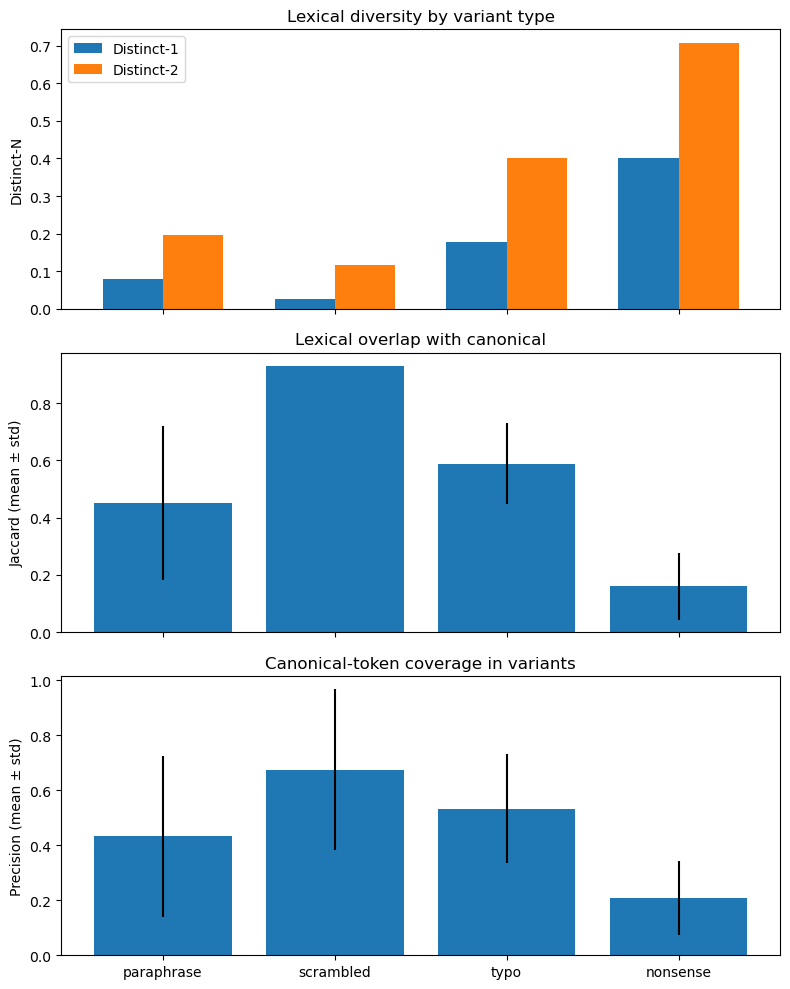

In [8]:
import json
import matplotlib.pyplot as plt

with open("metrics.json", "r") as f:
    metrics = json.load(f)["modes"]

modes = ["paraphrase", "scrambled", "typo", "nonsense"]

# Extract series
d1 = [metrics[m]["distinct_1"] for m in modes]
d2 = [metrics[m]["distinct_2"] for m in modes]

j_mean = [metrics[m]["lexical_jaccard_stats"]["mean"] for m in modes]
j_std  = [metrics[m]["lexical_jaccard_stats"]["std"]  for m in modes]

p_mean = [metrics[m]["lexical_precision_stats"]["mean"] for m in modes]
p_std  = [metrics[m]["lexical_precision_stats"]["std"]  for m in modes]

x = range(len(modes))

fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Panel A: Distinct-1/2
ax = axes[0]
width = 0.35
ax.bar([i - width/2 for i in x], d1, width, label="Distinct-1")
ax.bar([i + width/2 for i in x], d2, width, label="Distinct-2")
ax.set_ylabel("Distinct-N")
ax.set_title("Lexical diversity by variant type")
ax.legend()

# Panel B: Jaccard
ax = axes[1]
ax.bar(x, j_mean, yerr=j_std)
ax.set_ylabel("Jaccard (mean ± std)")
ax.set_title("Lexical overlap with canonical")

# Panel C: Precision
ax = axes[2]
ax.bar(x, p_mean, yerr=p_std)
ax.set_ylabel("Precision (mean ± std)")
ax.set_title("Canonical-token coverage in variants")
ax.set_xticks(list(x))
ax.set_xticklabels(modes)

plt.tight_layout()
plt.show()


In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
visualize_variant_metrics.py

Visualize intrinsic metrics for instruction variants (paraphrase, scrambled,
typo, nonsense) and save PNGs suitable for PowerPoint.

Input:
- variant_metrics.json with the structure you provided.

Outputs:
- variant_semantic_similarity.png
- variant_distinct_n.png
- variant_lexical_overlap.png
"""

import json
import matplotlib.pyplot as plt

METRICS_PATH = "metrics.json"

MODES_ORDER = ["paraphrase", "scrambled", "typo", "nonsense"]
MODE_LABELS = {
    "paraphrase": "Paraphrase",
    "scrambled": "Scrambled",
    "typo": "Typo",
    "nonsense": "Nonsense",
}


def load_variant_metrics(path: str):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    modes = data["modes"]

    labels = []
    distinct1 = []
    distinct2 = []
    jaccard_mean = []
    precision_mean = []
    sem_mean = []

    for m in MODES_ORDER:
        mdata = modes[m]
        labels.append(MODE_LABELS.get(m, m))

        distinct1.append(mdata["distinct_1"])
        distinct2.append(mdata["distinct_2"])

        jaccard_mean.append(mdata["lexical_jaccard_stats"]["mean"])
        precision_mean.append(mdata["lexical_precision_stats"]["mean"])

        sem_mean.append(mdata["semantic_similarity_stats"]["mean"])

    return labels, distinct1, distinct2, jaccard_mean, precision_mean, sem_mean


def plot_bar(values, labels, ylabel, title, filename, ylim=None, color=None):
    fig, ax = plt.subplots(figsize=(6, 4))

    x = range(len(labels))
    bars = ax.bar(x, values, color=color)  # <-- use color here

    if ylim is not None:
        ax.set_ylim(*ylim)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)

    top = ax.get_ylim()[1]
    for i, v in enumerate(values):
        y = min(v + 0.02 * top, top * 0.98)
        ax.text(
            i,
            y,
            f"{v:.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    fig.tight_layout()
    fig.savefig(filename, dpi=300)
    plt.close(fig)



def plot_grouped_bars(
    values_a,
    values_b,
    labels,
    legend_labels,
    ylabel,
    title,
    filename,
    ylim=None,
):
    fig, ax = plt.subplots(figsize=(6, 4))

    x = range(len(labels))
    width = 0.35  # bar width

    bars1 = ax.bar([i - width / 2 for i in x], values_a, width, label=legend_labels[0])
    bars2 = ax.bar([i + width / 2 for i in x], values_b, width, label=legend_labels[1])

    ax.set_xticks(list(x))
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)

    if ylim is not None:
        ax.set_ylim(*ylim)

    # numeric labels
    for bars in (bars1, bars2):
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=8,
            )

    ax.legend(fontsize=10)
    fig.tight_layout()
    fig.savefig(filename, dpi=300)
    plt.close(fig)


def main():
    (
        labels,
        distinct1,
        distinct2,
        jaccard_mean,
        precision_mean,
        sem_mean,
    ) = load_variant_metrics(METRICS_PATH)

    # 1) Semantic similarity per mode
    plot_bar(
        values=sem_mean,
        labels=labels,
        ylabel="Mean semantic similarity",
        title="Semantic Similarity vs Original Instruction",
        filename="variant_semantic_similarity.png",
        ylim=(0.0, 1.2),
        color="tab:orange"
    )

    # 2) Distinct-1 and Distinct-2 per mode
    plot_grouped_bars(
        values_a=distinct1,
        values_b=distinct2,
        labels=labels,
        legend_labels=["Distinct-1", "Distinct-2"],
        ylabel="Distinct-n",
        title="Lexical Diversity (Distinct-1/2) by Variant Type",
        filename="variant_distinct_n.png",
        ylim=(0.0, 0.8),
    )

    # 3) Lexical Jaccard and precision per mode
    plot_grouped_bars(
        values_a=jaccard_mean,
        values_b=precision_mean,
        labels=labels,
        legend_labels=["Jaccard (unique tokens)", "Precision (overlap)"],
        ylabel="Mean overlap",
        title="Lexical Overlap with Original Instruction",
        filename="variant_lexical_overlap.png",
        ylim=(0.0, 1.2),
    )

    print("Saved plots:")
    print("  - variant_semantic_similarity.png")
    print("  - variant_distinct_n.png")
    print("  - variant_lexical_overlap.png")


if __name__ == "__main__":
    main()


Saved plots:
  - variant_semantic_similarity.png
  - variant_distinct_n.png
  - variant_lexical_overlap.png


In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
visualize_cmas_eval.py

Load cmas_eval_metrics.json and create simple bar charts
(Base vs LoRA) for PowerPoint.

Outputs:
- levenshtein_comparison.png
- similarity_comparison.png
"""

import json
import matplotlib.pyplot as plt

METRICS_PATH = "cmas_eval_metrics.json"

def load_metrics(path: str):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    base = data["base"]
    lora = data["lora"]

    names = ["Base", "LoRA"]
    avg_lev = [base["avg_levenshtein"], lora["avg_levenshtein"]]
    avg_sim = [base["avg_norm_similarity"], lora["avg_norm_similarity"]]

    return names, avg_lev, avg_sim


def plot_bar(values, labels, ylabel, title, filename, color=None, y_limit=None):
    fig, ax = plt.subplots(figsize=(6, 4))

    x = range(len(labels))
    
    bars = ax.bar(x, values, color=color)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)

    if y_limit is not None:
        ax.set_ylim(y_limit)

    # Add numeric labels above bars
    for i, v in enumerate(values):
        ax.text(
            i,
            v,
            f"{v:.3f}" if v < 10 else f"{v:.1f}",
            ha="center",
            va="bottom",
            fontsize=11,
        )

    fig.tight_layout()
    fig.savefig(filename, dpi=300)
    plt.close(fig)


def main():
    names, avg_lev, avg_sim = load_metrics(METRICS_PATH)

    # 1) Levenshtein distance comparison
    plot_bar(
        values=avg_lev,
        labels=names,
        ylabel="Avg Levenshtein distance (↓ better)",
        title="Average Edit Distance to Gold CMAS Goal",
        filename="levenshtein_comparison.png",
        color="tab:orange",
        y_limit=(0.0, 1000),
    )

    # 2) Normalized similarity comparison
    plot_bar(
        values=avg_sim,
        labels=names,
        ylabel="Avg normalized similarity (↑ better)",
        title="Average Normalized Similarity to Gold",
        filename="similarity_comparison.png",
        color="tab:orange",
        y_limit=(0.0, 1.1),  # similarity is in [0,1]
    )

    print("Saved plots:")
    print("  - levenshtein_comparison.png")
    print("  - similarity_comparison.png")


if __name__ == "__main__":
    main()


Saved plots:
  - levenshtein_comparison.png
  - similarity_comparison.png
